## Step 1. EDA

1. Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")
%matplotlib inline

DATA_DIR = os.path.join(os.getcwd(), "../data")
fn = os.path.join(DATA_DIR, "heart_disease_uci.csv") 
print("Data file:", fn)

Data file: /Users/konstantinoskalaitzidis/Developer/heart-disease-prediction/notebooks/../data/heart_disease_uci.csv


2. Load dataset and preview

In [2]:
df = pd.read_csv(fn)
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


3. quick overview

In [3]:
print(df.shape)           # rows, columns
print(df.columns.tolist())# feature names
print(df.info())          # data types and non-null counts
print(df.describe())      # summary statistics

(920, 16)
['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory 

This dataset contains 920 rows and 16 columns (features)

4. Check missing values

In [4]:
print(df.isnull().sum())

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


Some columns have a lot of missing values (slope, ca, thal), more than 50% in some cases. Others have moderate missing values (trestbps, chol, fbs, thalch, exang, oldpeak). The restecg feature has very few missing values, so it’s easier to handle.

5. Data Cleaning

In [5]:
# Drop columns with too many missing values
df_clean = df.drop(columns=["ca", "thal", "slope"])

# Impute categorical/binary features with mode
for col in ["fbs", "exang"]:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Impute remaining numeric missing values with median
for col in df_clean.select_dtypes(include=np.number).columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Impute restecg with mode
df_clean["restecg"].fillna(df_clean["restecg"].mode()[0], inplace=True)

df_clean.isnull().sum() # Check missing values again

/var/folders/4n/41px7rn169s5k2y3v36v4l740000gn/T/ipykernel_75847/376792942.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
/var/folders/4n/41px7rn169s5k2y3v36v4l740000gn/T/ipykernel_75847/376792942.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64

Now we can continue with exploring the dataset

6. Target variable distribution

The feature "num" is our target variable. Its value range from 0 to 4 meaning that this dataset is suitable as a multiclass classification problem. Lets see if the classes are balanced. 

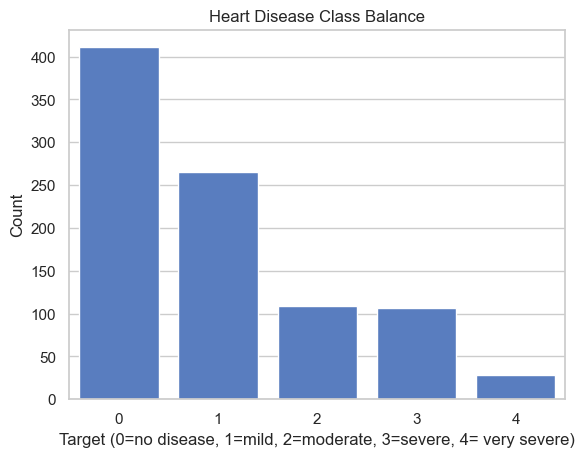

num
0    44.673913
1    28.804348
2    11.847826
3    11.630435
4     3.043478
Name: proportion, dtype: float64


In [6]:
target = "num"
sns.countplot(x=target, data=df)
plt.title("Heart Disease Class Balance")
plt.xlabel("Target (0=no disease, 1=mild, 2=moderate, 3=severe, 4= very severe)")
plt.ylabel("Count")
plt.show()

# Optional: percentage
print(df[target].value_counts(normalize=True) * 100)

About 45% of patients have num = 0 → no heart disease
The remaining 55% have num = 1–4 → some level of heart disease
So the dataset is not extremely imbalanced, but it’s also not perfectly balanced. Roughly 45% vs 55% if we convert it to a binary problem (target = 0 or 1).

7. Feature distributions (optional)

In [7]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove(target)

# df[numeric_features].hist(figsize=(15,10), bins=20)
# plt.suptitle("Numeric Feature Distributions")
# plt.show()

8. Correlation Heatmap

The correlation between a feature and the target variable (num) will tell us which features are important. 

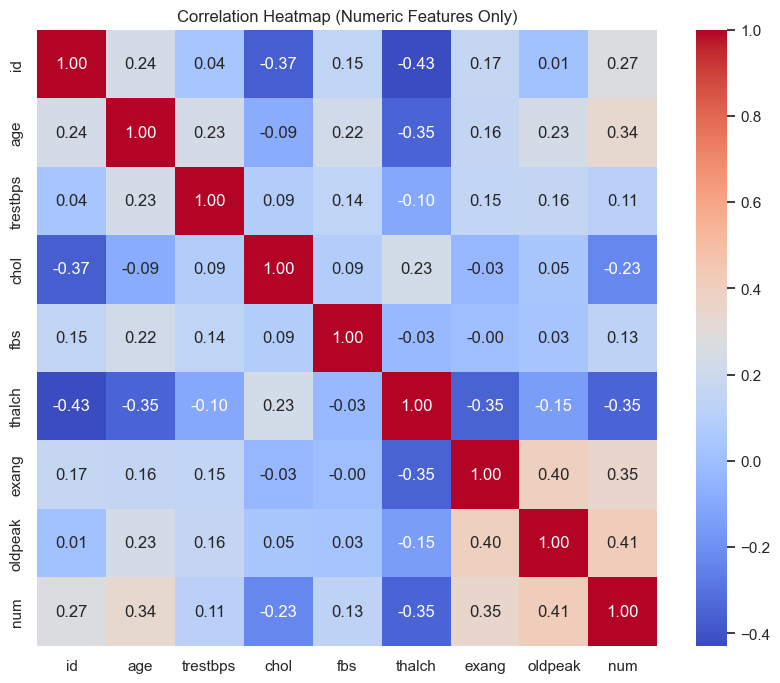

In [8]:
# Select only numeric columns
numeric_df = df_clean.select_dtypes(include=['float64', 'int64', 'bool'])

# Compute correlation
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numeric Features Only)')
plt.show()

We can see that features such as: oldpeak, exang, fbs, trestbps and age, have a a positive correlation with the target variable

9. Boxplots for features by target

In [9]:
# for col in numeric_features:
#     plt.figure(figsize=(6,4))
#     sns.boxplot(x=target, y=col, data=df)
#     plt.title(f"{col} distribution by Heart Disease")
#     plt.show()


10. Optional: pairplot

In [10]:
# sns.pairplot(df, hue=target, vars=numeric_features[:5])  # first 5 features for clarity
# plt.show()

11. Convert the problem from multiclass to binary

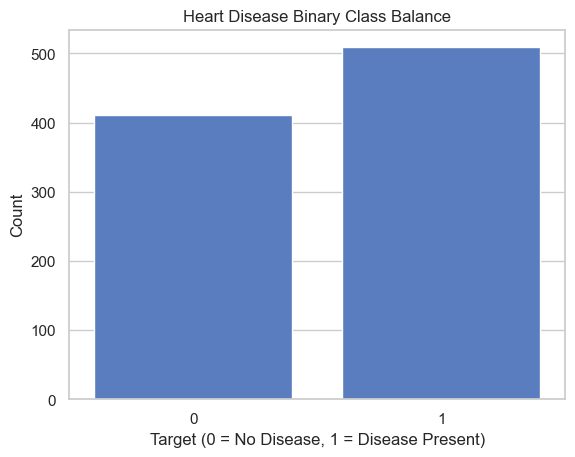

target
1    55.326087
0    44.673913
Name: proportion, dtype: float64


In [11]:
# Convert to binary classification
df_clean['target'] = df_clean['num'].apply(lambda x: 0 if x == 0 else 1)

# Verify distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=df_clean)
plt.title('Heart Disease Binary Class Balance')
plt.xlabel('Target (0 = No Disease, 1 = Disease Present)')
plt.ylabel('Count')
plt.show()

# Print percentages
print(df_clean['target'].value_counts(normalize=True) * 100)


Now its more clear for us to define our RQ: Can we predict whether a patient has heart disease based on clinical features, and which features contribute most to this prediction?


## Step 2 — Feature Engineering & Selection

2.1 Drop unused columns

In [ ]:
df_model = df_clean.drop(columns=['id', 'num'])

In [ ]:
df_model.head()

2.2 Identify column types

In [ ]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'dataset']
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']